# 3.3 糖尿病の予後予測【サンプルコード】

In [ ]:
# 必要なパッケージのインストール
!pip3 install torch==1.5.1+cu101
!pip3 install torchvision==0.6.1+cu101
!pip3 install numpy==1.19.0
!pip3 install matplotlib==3.2.2
!pip3 install scikit-learn==0.23.1
!pip3 install seaborn==0.10.1

In [ ]:
# 必要なパッケージのインストール
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 3.3.1 糖尿病（Diabetes）データセット

In [ ]:
# データセットのロード
diabetes = load_diabetes()

In [ ]:
# データセットの説明
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [ ]:
# データフレームに変換
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
# 1年後の進行度の追加
df['target'] = diabetes.target
print(df.head())

        age       sex       bmi        bp  ...        s4        s5        s6  target
0  0.038076  0.050680  0.061696  0.021872  ... -0.002592  0.019908 -0.017646   151.0
1 -0.001882 -0.044642 -0.051474 -0.026328  ... -0.039493 -0.068330 -0.092204    75.0
2  0.085299  0.050680  0.044451 -0.005671  ... -0.002592  0.002864 -0.025930   141.0
3 -0.089063 -0.044642 -0.011595 -0.036656  ...  0.034309  0.022692 -0.009362   206.0
4  0.005383 -0.044642 -0.036385  0.021872  ... -0.002592 -0.031991 -0.046641   135.0

[5 rows x 11 columns]


In [ ]:
# 基本統計量の確認
print(df.describe())

                age           sex  ...            s6      target
count  4.420000e+02  4.420000e+02  ...  4.420000e+02  442.000000
mean  -3.634285e-16  1.308343e-16  ... -3.412882e-16  152.133484
std    4.761905e-02  4.761905e-02  ...  4.761905e-02   77.093005
min   -1.072256e-01 -4.464164e-02  ... -1.377672e-01   25.000000
25%   -3.729927e-02 -4.464164e-02  ... -3.317903e-02   87.000000
50%    5.383060e-03 -4.464164e-02  ... -1.077698e-03  140.500000
75%    3.807591e-02  5.068012e-02  ...  2.791705e-02  211.500000
max    1.107267e-01  5.068012e-02  ...  1.356118e-01  346.000000

[8 rows x 11 columns]


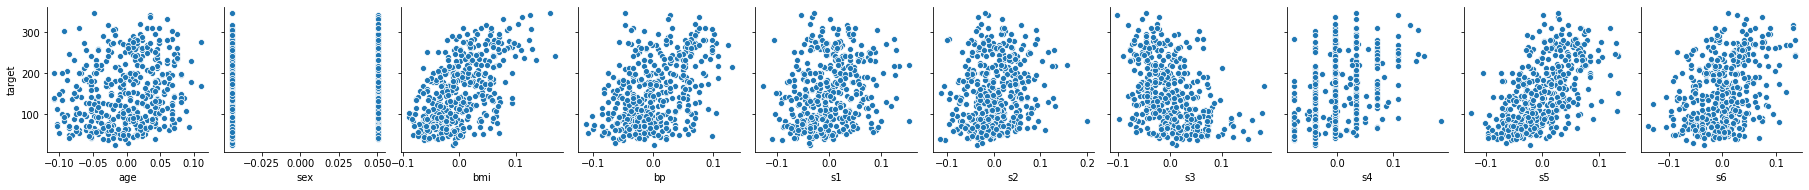

In [ ]:
# データセットの可視化
sns.pairplot(df, x_vars=diabetes.feature_names, y_vars='target')
plt.show()

## 3.3.2 前準備

In [ ]:
# データセットの読み込み
diabetes = load_diabetes()
data = diabetes.data  # 特徴量
label = diabetes.target.reshape(-1, 1)  # 一年後の糖尿病の進行度

# データセットのサイズの確認
print("data size: {}".format(data.shape))
print("label size: {}".format(label.shape))

data size: (442, 10)
label size: (442, 1)


## 3.3.3 訓練データとテストデータの用意

In [ ]:
# 学習データとテストデータを分割
train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.2)

# 学習データとテストデータのサイズの確認
print("train_data size: {}".format(len(train_data)))
print("test_data size: {}".format(len(test_data)))
print("train_label size: {}".format(len(train_label)))
print("test_label size: {}".format(len(test_label)))

train_data size: 353
test_data size: 89
train_label size: 353
test_label size: 89


In [ ]:
# ndarrayをPyTorchのTensorに変換
train_x = torch.Tensor(train_data)
test_x = torch.Tensor(test_data)
train_y = torch.Tensor(train_label)  # torch.float32のデータ型に
test_y = torch.Tensor(test_label)  # torch.float32のデータ型に

In [ ]:
# 特徴量とラベルを結合したデータセットを作成
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

In [ ]:
# ミニバッチサイズを指定したデータローダーを作成
train_batch = DataLoader(
    dataset=train_dataset,  # データセットの指定
    batch_size=20,  # バッチサイズの指定
    shuffle=True,  # シャッフルするかどうかの指定
    num_workers=2)  # コアの数
test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=20,
    shuffle=False,
    num_workers=2)

# ミニバッチデータセットの確認
for data, label in train_batch:
    print("batch data size: {}".format(data.size()))  # バッチの入力データサイズ
    print("batch label size: {}".format(label.size()))  # バッチのラベルサイズ
    break

batch data size: torch.Size([20, 10])
batch label size: torch.Size([20, 1])


## 3.3.4 ニューラルネットワークの定義

In [ ]:
# ニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, H)  # 追加
        self.linear3 = nn.Linear(H, D_out)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))  # 追加
        x = F.relu(self.linear2(x))  # 追加
        x = self.dropout(x)  # 追加
        x = self.linear3(x)
        return x

In [ ]:
# ハイパーパラメータの定義
D_in = 10  # 入力次元: 10
H = 200  # 隠れ層次元: 200
D_out = 1  # 出力次元: 1
epoch = 100  # 学習回数: 100

In [ ]:
# ネットワークのロード
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net(D_in, H, D_out).to(device)
# デバイスの確認
print("Device: {}".format(device))

Device: cuda


## 3.3.5 損失関数と最適化関数の定義

In [ ]:
# 損失関数の定義
criterion = nn.MSELoss()  # 今回の損失関数（平均二乗誤差: MSE）
criterion2 = nn.L1Loss()  # 参考用（平均絶対誤差: MAE）

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())

## 3.3.6 学習

In [ ]:
# 損失を保存するリストを作成
train_loss_list = []  # 学習損失（MSE）
test_loss_list = []  # 評価損失（MSE）
train_mae_list = []  # 学習MAE
test_mae_list = []  # 評価MAE

# 学習（エポック）の実行
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失の初期化
    train_loss = 0  # 学習損失（MSE）
    test_loss = 0  # 評価損失（MSE）
    train_mae = 0  # 学習MAE
    test_mae = 0  # 評価MAE

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    for data, label in train_batch:
        # GPUにTensorを転送
        data = data.to(device)
        label = label.to(device)

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred = net(data)
        # 損失（誤差）を計算
        loss = criterion(y_pred, label)  # MSE
        mae = criterion2(y_pred, label)  # MAE
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()
        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()  # MSE
        train_mae += mae.item()  # MAE

    # ミニバッチの平均の損失を計算
    batch_train_loss = train_loss / len(train_batch.dataset)
    batch_train_mae = train_mae / len(train_batch.dataset)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for data, label in test_batch:
            # GPUにTensorを転送
            data = data.to(device)
            label = label.to(device)
            # データを入力して予測値を計算（順伝播）
            y_pred = net(data)
            # 損失（誤差）を計算
            loss = criterion(y_pred, label)  # MSE
            mae = criterion2(y_pred, label)  # MAE
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()  # MSE
            test_mae += mae.item()  # MAE

    # ミニバッチの平均の損失を計算
    batch_test_loss = test_loss / len(test_batch.dataset)
    batch_test_mae = test_mae / len(test_batch.dataset)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失を表示
    print("Train_Loss: {:.4f} Train_MAE: {:.4f}".format(
        batch_train_loss, batch_train_mae))
    print("Test_Loss: {:.4f} Test_MAE: {:.4f}".format(
        batch_test_loss, batch_test_mae))
    # 損失をリスト化して保存
    train_loss_list.append(batch_train_loss)
    test_loss_list.append(batch_test_loss)
    train_mae_list.append(batch_train_mae)
    test_mae_list.append(batch_test_mae)

---------------------------------------------
Epoch: 1/100
Train_Loss: 1430.1809 Train_MAE: 7.5993
Test_Loss: 1698.0575 Test_MAE: 8.7600
---------------------------------------------
Epoch: 2/100
Train_Loss: 1355.2509 Train_MAE: 7.3446
Test_Loss: 1489.6932 Test_MAE: 8.0713
---------------------------------------------
Epoch: 3/100
Train_Loss: 999.0498 Train_MAE: 5.9590
Test_Loss: 802.8845 Test_MAE: 5.3861
---------------------------------------------
Epoch: 4/100
Train_Loss: 402.9118 Train_MAE: 3.5892
Test_Loss: 283.0748 Test_MAE: 3.4949
---------------------------------------------
Epoch: 5/100
Train_Loss: 283.9464 Train_MAE: 3.2451
Test_Loss: 266.3565 Test_MAE: 3.3134
---------------------------------------------
Epoch: 6/100
Train_Loss: 247.2537 Train_MAE: 2.9663
Test_Loss: 253.8227 Test_MAE: 3.2150
---------------------------------------------
Epoch: 7/100
Train_Loss: 246.1696 Train_MAE: 3.0036
Test_Loss: 239.5992 Test_MAE: 3.1231
---------------------------------------------
Epoch

## 3.3.7 結果の可視化

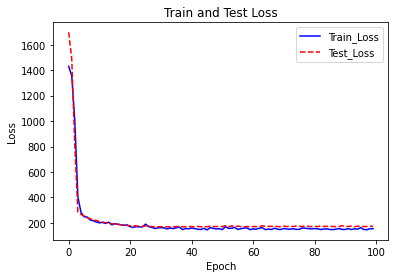

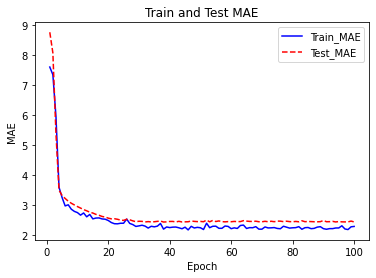

In [ ]:
# 損失（MSE）
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(epoch), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(epoch), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')
plt.legend()  # 凡例

# MAE
plt.figure()
plt.title('Train and Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(range(1, epoch+1), train_mae_list, color='blue',
         linestyle='-', label='Train_MAE')
plt.plot(range(1, epoch+1), test_mae_list, color='red',
         linestyle='--', label='Test_MAE')
plt.legend()  # 凡例

# 表示
plt.show()